# Ensemble learning: QRT Challenge

## Load libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from prophet.diagnostics import cross_validation
from prophet import Prophet
import numpy as np
from scipy.stats import spearmanr
from sklearn.metrics import make_scorer
from sklearn.impute import KNNImputer

## Load file

In [2]:
#Google Drive access
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
X_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ensemble_learning/X_train_NHkHMNU.csv")
X_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ensemble_learning/X_test_final.csv")
y_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/ensemble_learning/y_train_ZAN5mwg.csv")

## Data cleaning

In [4]:
#Missing values
missing_values_count_train = X_train.isnull().sum()/len(X_train)*100
missing_values_count_test = X_test.isnull().sum()/len(X_train)*100

print("Missing Values per Variable in %:")
print(missing_values_count_train)

Missing Values per Variable in %:
ID                  0.000000
DAY_ID              0.000000
COUNTRY             0.000000
DE_CONSUMPTION      0.000000
FR_CONSUMPTION      0.000000
DE_FR_EXCHANGE      1.673360
FR_DE_EXCHANGE      1.673360
DE_NET_EXPORT       8.299866
FR_NET_EXPORT       4.685408
DE_NET_IMPORT       8.299866
FR_NET_IMPORT       4.685408
DE_GAS              0.000000
FR_GAS              0.000000
DE_COAL             0.000000
FR_COAL             0.000000
DE_HYDRO            0.000000
FR_HYDRO            0.000000
DE_NUCLEAR          0.000000
FR_NUCLEAR          0.000000
DE_SOLAR            0.000000
FR_SOLAR            0.000000
DE_WINDPOW          0.000000
FR_WINDPOW          0.000000
DE_LIGNITE          0.000000
DE_RESIDUAL_LOAD    0.000000
FR_RESIDUAL_LOAD    0.000000
DE_RAIN             6.291834
FR_RAIN             6.291834
DE_WIND             6.291834
FR_WIND             6.291834
DE_TEMP             6.291834
FR_TEMP             6.291834
GAS_RET             0.000000
COAL_RET 

In [5]:
def preprocessing(df,value):
  ## FIND COLUMNS WITH MISSING VALUE
  missing_values_count = df.isnull().sum()/len(df)*100
  columns_with_missing_values = missing_values_count[missing_values_count > 0].index.tolist()
  columns_with_missing_values = list(set(columns_with_missing_values))

  ## INPUT MISSING VALUE WITH KNNIMPUTER
  knn_imputer = KNNImputer(n_neighbors=5)
  df[columns_with_missing_values] = knn_imputer.fit_transform(df[columns_with_missing_values])

  ## DUMMY ENCONDING
  df['FRANCE'] = df['COUNTRY'].apply(lambda x: 1 if x == 'FR' else 0)
  df['DEUTSCHLAND'] = df['COUNTRY'].apply(lambda x: 1 if x == 'DE' else 0)
  df = df.drop(columns = ['COUNTRY'])

  ## DROP HIGH CORRELATION COL
  high_corr_columns = []
  if value == 'train' and y_train is not None:
      merged_data = df.merge(y_train, how='inner', on='ID')
      corr_matrix = merged_data.corr()

      for i in range(len(corr_matrix.columns)):
          for j in range(i):
              if abs(corr_matrix.iloc[i, j]) > 0.9:
                  colname = corr_matrix.columns[i]  # Nom de la colonne ayant une forte corrélation
                  if corr_matrix.columns[j] not in high_corr_columns:
                      high_corr_columns.append(colname)

      df = df.drop(columns=high_corr_columns)

  if value == 'test':
      corr_matrix = df.corr()

      for i in range(len(corr_matrix.columns)):
          for j in range(i):
              if abs(corr_matrix.iloc[i, j]) > 0.9:
                  colname = corr_matrix.columns[i]  # Nom de la colonne ayant une forte corrélation
                  if corr_matrix.columns[j] not in high_corr_columns:
                      high_corr_columns.append(colname)

      df = df.drop(columns=high_corr_columns)


  ## ADD DATE COL
  start_date = pd.to_datetime('2020-01-01')
  df['DATE'] = df['DAY_ID'].apply(lambda x: start_date + pd.Timedelta(days=x-1))




  return df


X_train  = preprocessing(X_train, 'train')
X_test = preprocessing(X_test, 'test')

# Data Visualisation

<ipython-input-6-e34befcc9c31>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = merged_data.corr()


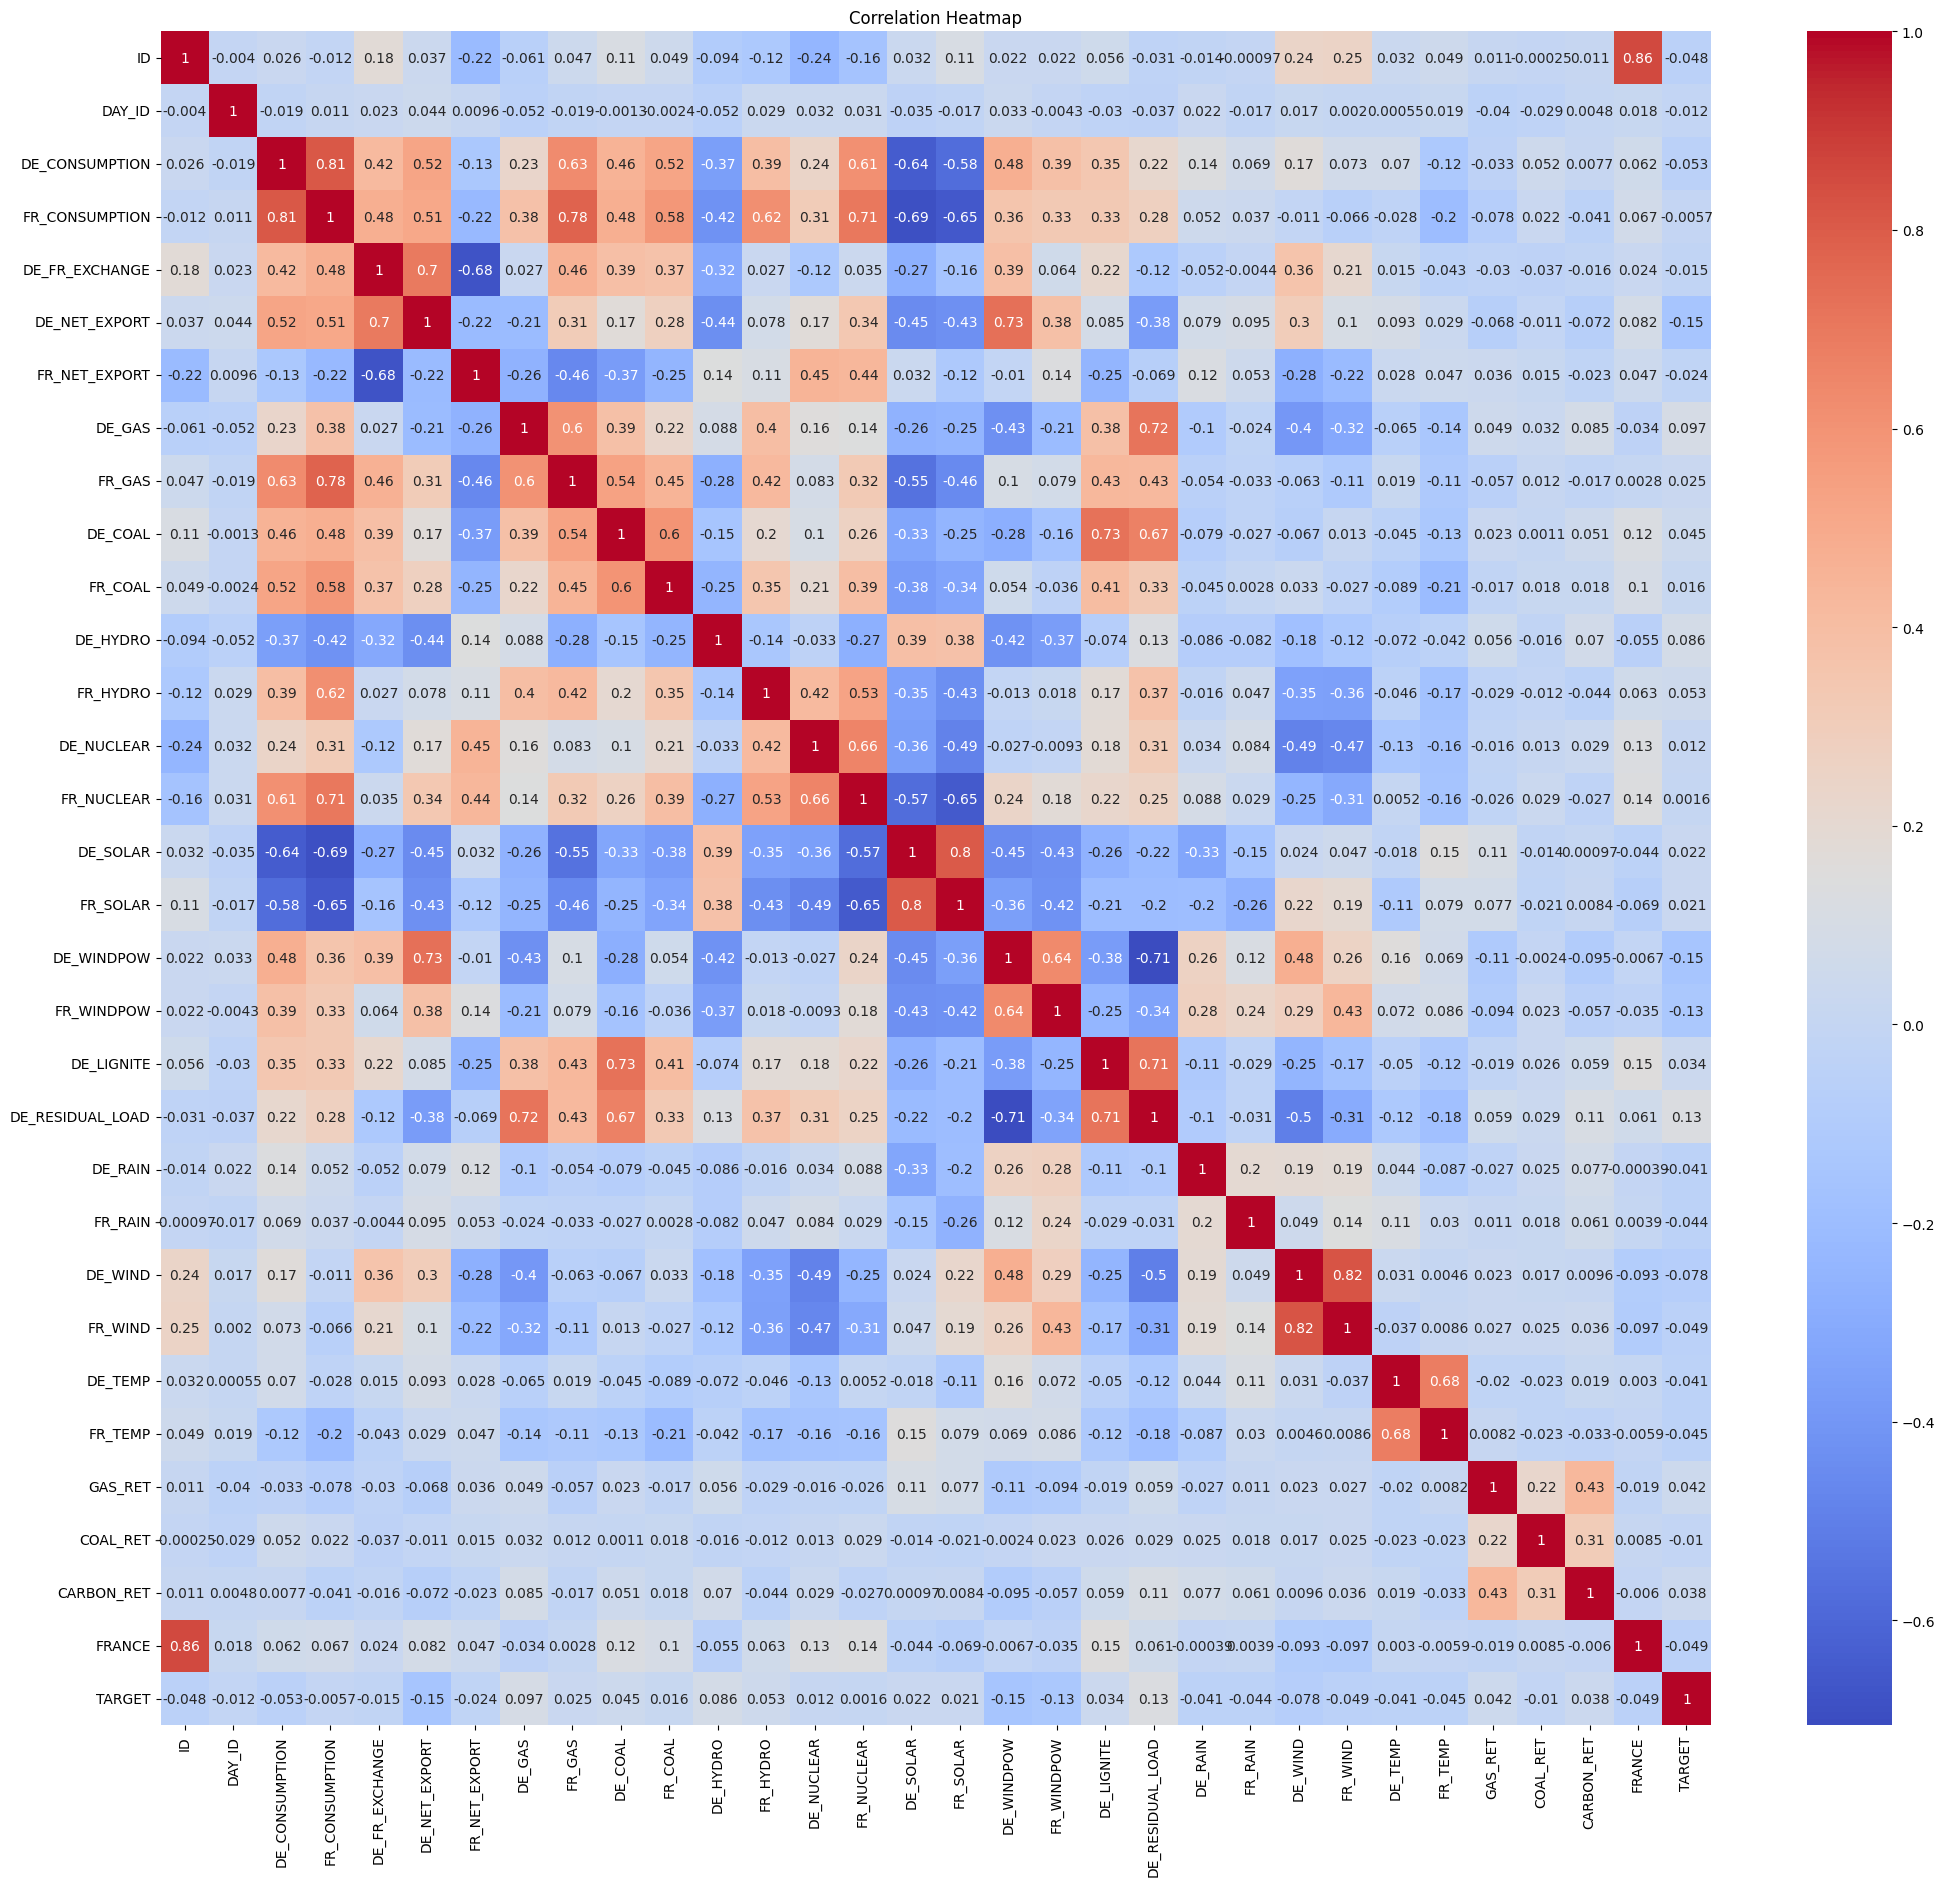

In [6]:
merged_data = X_train.merge(y_train, how = 'inner', on = 'ID')
#Corrélation
corr_matrix = merged_data.corr()

#Heatmap
plt.figure(figsize=(25, 22))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [7]:
summary_stats = merged_data.describe()

# Display the mean, standard deviation, and other metrics for the 'TARGET' column
target_stats = merged_data['TARGET'].describe()

print("Summary Statistics for All Columns:")
print(summary_stats)

print("\nSummary Statistics for 'TARGET' Column:")
print(target_stats)

Summary Statistics for All Columns:
                ID       DAY_ID  DE_CONSUMPTION  FR_CONSUMPTION  \
count  1494.000000  1494.000000     1494.000000     1494.000000   
mean   1072.759036   591.861446        0.427442       -0.020032   
std     618.013179   345.065043        0.673412        0.918995   
min       0.000000     0.000000       -2.265563       -1.462350   
25%     540.250000   292.250000       -0.037421       -0.716771   
50%    1077.500000   591.000000        0.357061       -0.394166   
75%    1597.500000   885.750000        0.922057        0.650533   
max    2146.000000  1215.000000        2.033851        3.300640   

       DE_FR_EXCHANGE  DE_NET_EXPORT  FR_NET_EXPORT       DE_GAS       FR_GAS  \
count     1494.000000    1494.000000    1494.000000  1494.000000  1494.000000   
mean        -0.145479      -0.240018      -0.067991     0.780699     0.395019   
std          0.965617       0.932575       1.057253     0.850190     0.906500   
min         -2.856874      -2.464849

# Modelling

# Prophet Modeling - BaseLine Model

In [19]:
# Merge X_train and Y_train
train_data = X_train.merge(y_train, on='ID')

# Selecting the 'DAY_ID' and 'TARGET' for Prophet
prophet_train_data = train_data[['DATE', 'TARGET']]
prophet_train_data.rename(columns={'DATE': 'ds', 'TARGET': 'y'}, inplace=True)


<ipython-input-19-4fee8da989d4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prophet_train_data.rename(columns={'DATE': 'ds', 'TARGET': 'y'}, inplace=True)


In [21]:
from prophet import Prophet

# Initialize the Prophet model
model = Prophet(daily_seasonality=True)

# If you have additional regressors, add them like this:
# model.add_regressor('feature_name')

model.fit(prophet_train_data)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpxjvfrnty/_pec5_03.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxjvfrnty/z4_eim_z.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93471', 'data', 'file=/tmp/tmpxjvfrnty/_pec5_03.json', 'init=/tmp/tmpxjvfrnty/z4_eim_z.json', 'output', 'file=/tmp/tmpxjvfrnty/prophet_modelwzoercey/prophet_model-20240223221311.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [22]:
future = model.make_future_dataframe(periods=len(X_test), freq='D')
# If you have additional regressors in the test set, add them to the future dataframe

forecast = model.predict(future)


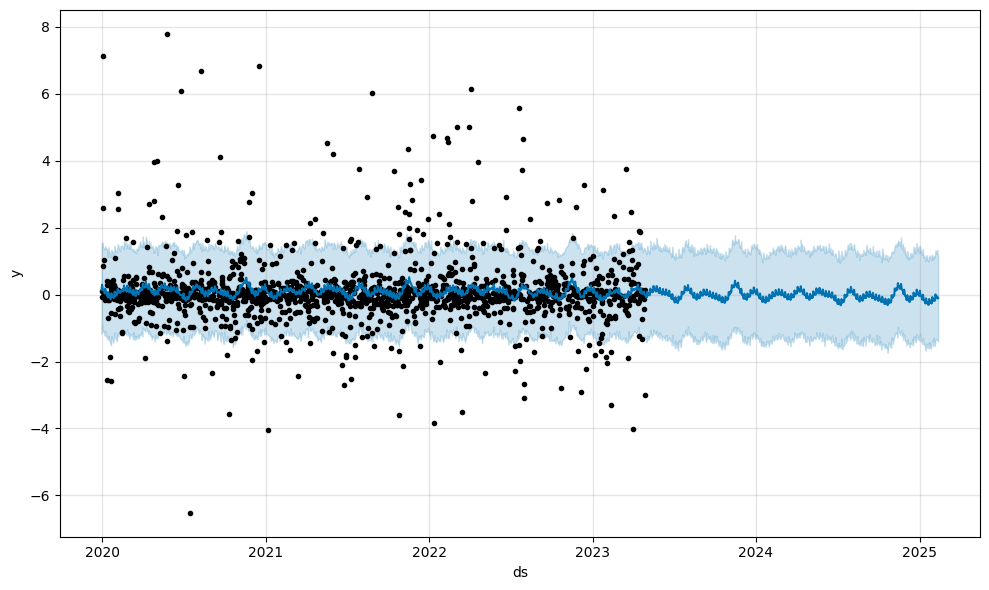

In [23]:
# Tracer les prévisions
fig1 = model.plot(forecast)


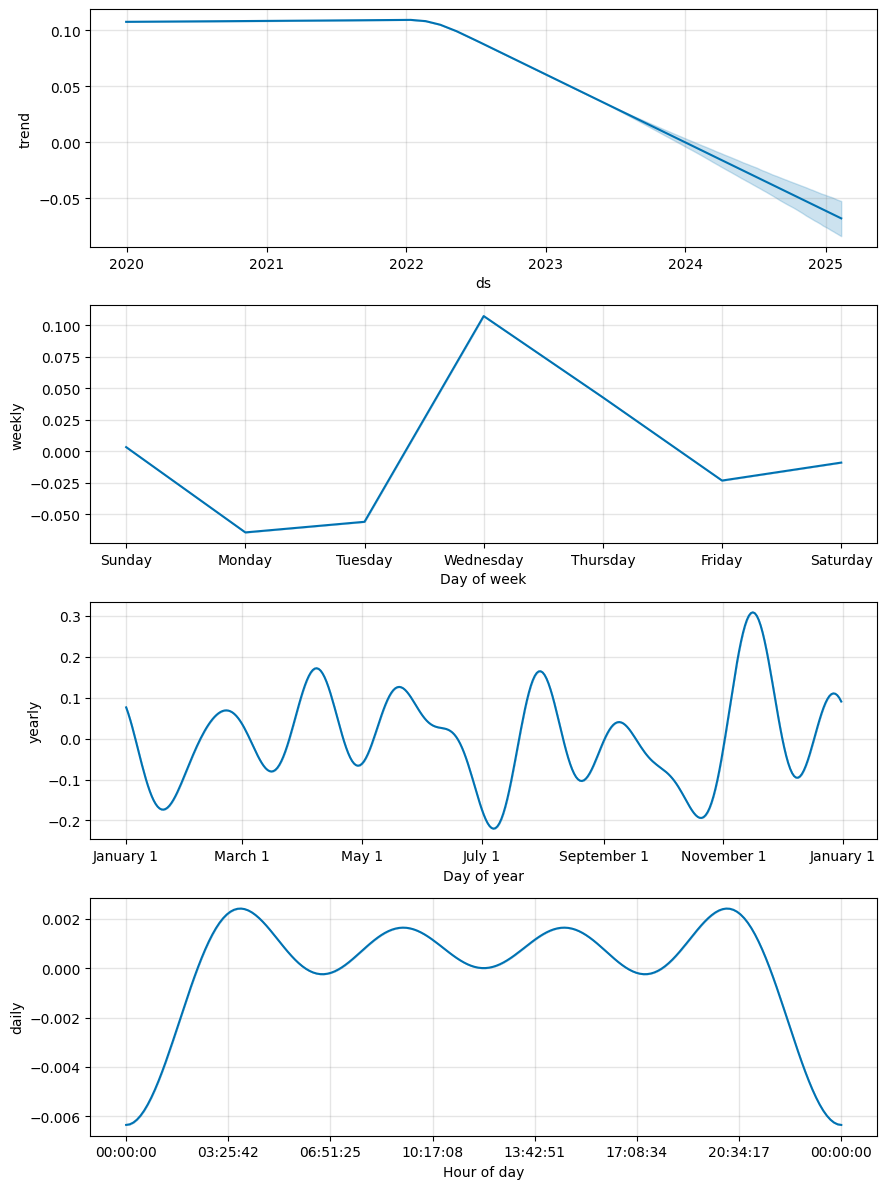

In [12]:
# Tracer les composants des prévisions (tendance, saisonnalité annuelle, hebdomadaire, etc.)
fig2 = model.plot_components(forecast)


In [13]:
# Calculate Spearman's correlation
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon = '365 days')
spearman_corr = spearmanr(df_cv['y'], df_cv['yhat'])

print(f"Spearman's correlation coefficient: {spearman_corr.correlation}")

INFO:prophet:Making 1 forecasts with cutoffs between 2022-04-29 00:00:00 and 2022-04-29 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpxjvfrnty/0x9xp9aw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxjvfrnty/jockno9r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17856', 'data', 'file=/tmp/tmpxjvfrnty/0x9xp9aw.json', 'init=/tmp/tmpxjvfrnty/jockno9r.json', 'output', 'file=/tmp/tmpxjvfrnty/prophet_model3ll3djzn/prophet_model-20240223220955.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:09:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:09:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Spearman's correlation coefficient: -0.07024873862717847


## Split train test to test the model

In [14]:
def spearman_scorer(y_true, y_pred):
    # Calculate Spearman's correlation
    correlation, _ = spearmanr(y_true, y_pred)
    return correlation

# Create a scorer that can be used in GridSearchCV
spearman_scoring = make_scorer(spearman_scorer)

# Preprocess for Gradiant Boosting

In [15]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from statsmodels.tsa.stattools import acf

def optimize_lags_and_train_model(X_train, y_train, max_lag=100, n_estimators=1000, learning_rate=0.1, value= 'train'):
    """
    Optimise les décalages pour les caractéristiques de X_train basé sur l'autocorrélation
    et entraîne un modèle de Gradient Boosting avec ces caractéristiques optimisées.

    :param X_train: DataFrame des caractéristiques d'entraînement.
    :param y_train: Série ou array de la cible d'entraînement.
    :param max_lag: Le nombre maximal de décalages à examiner pour chaque caractéristique.
    :param n_estimators: Le nombre d'arbres pour le Gradient Boosting.
    :param learning_rate: Le taux d'apprentissage pour le Gradient Boosting.
    :return: Le modèle entraîné et le DataFrame d'entraînement avec les caractéristiques optimisées.
    """
    def preprocess_dates(df):
      date_columns = df.select_dtypes(include=['datetime64[ns]']).columns
      for col in date_columns:
          # Exemple d'extraction de caractéristiques temporelles
          df[f'{col}_year'] = df[col].dt.year
          df[f'{col}_month'] = df[col].dt.month
          df[f'{col}_day'] = df[col].dt.day
          # Supprimer la colonne de date originale
          df = df.drop(columns=[col])
      return df

    if value == 'train':
      # Appliquer la fonction de prétraitement des dates avant le reste du prétraitement
      X_train = preprocess_dates(X_train)

      # Copie du DataFrame pour ajouter les décalages
      X_train_optimized = X_train.copy()

      for column in X_train.columns:
          # Calcul de l'autocorrélation pour chaque décalage
          autocorr_lags = [acf(X_train[column].shift(lag+1).fillna(method='bfill'), nlags=1)[1] for lag in range(max_lag)]

          # Identification du décalage avec la plus forte autocorrélation
          best_lag = np.argmax(autocorr_lags) + 1  # +1 pour ajuster l'index 0

          # Si le meilleur décalage est significatif, créer une nouvelle caractéristique décalée
          if autocorr_lags[best_lag-1] > 0.4:  # Seuil arbitraire de significativité
              X_train_optimized[f'{column}_lag_{best_lag}'] = X_train[column].shift(best_lag).fillna(method='bfill')

      # Entraînement du modèle de Gradient Boosting avec les caractéristiques optimisées
      model = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate)
      model.fit(X_train_optimized, y_train.drop(columns = ['ID']).values.ravel())

      return model, X_train_optimized

    if value == 'test':
      # Appliquer la fonction de prétraitement des dates avant le reste du prétraitement
      X_test = preprocess_dates(X_train)

      # Copie du DataFrame pour ajouter les décalages
      X_test_optimized = X_test.copy()

      for column in X_test.columns:
          # Calcul de l'autocorrélation pour chaque décalage
          autocorr_lags = [acf(X_test[column].shift(lag+1).fillna(method='bfill'), nlags=1)[1] for lag in range(max_lag)]

          # Identification du décalage avec la plus forte autocorrélation
          best_lag = np.argmax(autocorr_lags) + 1  # +1 pour ajuster l'index 0

          # Si le meilleur décalage est significatif, créer une nouvelle caractéristique décalée
          if autocorr_lags[best_lag-1] > 0.4:  # Seuil arbitraire de significativité
              X_test_optimized[f'{column}_lag_{best_lag}'] = X_test[column].shift(best_lag).fillna(method='bfill')
      return X_test_optimized

# Pour l'entraînement
model, X_train_optimized = optimize_lags_and_train_model(X_train, y_train, value='train')

# Pour le test
X_test_optimized = optimize_lags_and_train_model(X_test, y_train=None, value='test')



In [16]:

X_train_optimized.shape

(1494, 34)

In [17]:
# Determine the split point for creating a validation set from the training data
split_ratio = 0.8  # for example, 80% of the data for training, 20% for validation
split_index = int(len(X_train_optimized) * split_ratio)

# Split the training data and outputs into training and validation sets
X_train_split = X_train_optimized.iloc[:split_index]
Y_train_split = y_train.iloc[:split_index]
X_val_split = X_train_optimized.iloc[split_index:]
Y_val_split = y_train.iloc[split_index:]

## Gradient boosting

In [18]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

#Create a gradient boosting model
grid_search = GridSearchCV(model, param_grid, scoring=spearman_scoring, cv=5)

grid_search.fit(X_train_split, Y_train_split.drop(columns = ['ID']).values.ravel())

#Get the best parameters
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

predictions = best_estimator.predict(X_val_split)

#Make predictions on the test set
cv_scores = cross_val_score(best_estimator, X_val_split, Y_val_split.drop(columns = ['ID']).values.ravel(), scoring='neg_mean_squared_error', cv=5)
cv_mse = -cv_scores.mean()

mse = mean_squared_error(Y_val_split.drop(columns = ['ID']).values.ravel(), predictions)


spearman_corr = spearmanr(Y_val_split.drop(columns = ['ID']).values.ravel(), predictions).correlation

print(f'Improved Mean Squared Error on Test Set: {mse}')
print(f'Cross-Validation Mean Squared Error: {cv_mse}')
print(f'Spearman Correlation on Test Set: {spearman_corr}')
print(f'Grid Search Best Params : {grid_search.best_params_}')

KeyboardInterrupt: 

## Adaboost

In [ ]:
base_model = DecisionTreeRegressor(max_depth=3)
adaboost_model = AdaBoostRegressor(base_model)
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2]
}


#Create a gradient boosting model
grid_search = GridSearchCV(adaboost_model, param_grid, scoring=spearman_scoring, cv=5)

grid_search.fit(X_train_split, Y_train_split.drop(columns = ['ID']).values.ravel())

#Get the best parameters
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

predictions = best_estimator.predict(X_val_split)

#Make predictions on the test set
cv_scores = cross_val_score(best_estimator, X_val_split, Y_val_split.drop(columns = ['ID']).values.ravel(), scoring='neg_mean_squared_error', cv=5)
cv_mse = -cv_scores.mean()

mse = mean_squared_error(Y_val_split.drop(columns = ['ID']).values.ravel(), predictions)


spearman_corr = spearmanr(Y_val_split.drop(columns = ['ID']).values.ravel(), predictions).correlation

print(f'Improved Mean Squared Error on Test Set: {mse}')
print(f'Cross-Validation Mean Squared Error: {cv_mse}')
print(f'Spearman Correlation on Test Set: {spearman_corr}')
print(f'Grid Search Best Params : {grid_search.best_params_}')

In [ ]:
base_model = DecisionTreeRegressor(max_depth=3)

adaboost_model = AdaBoostRegressor(base_model)

#Hyperparameter tunning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2]
}

#GridSearchCV
grid_search_adaboost = GridSearchCV(adaboost_model, param_grid, scoring=spearman_scoring, cv=5)

grid_search_adaboost.fit(X_train_split, Y_train_split)

#Best params
best_params_adaboost = grid_search_adaboost.best_params_

#New Adaboost model with the best params
best_adaboost_model = AdaBoostRegressor(base_model, **best_params_adaboost)

#Train the model with the best parameters
best_adaboost_model.fit(X_train_model, y_train_model)

#Predictions on the test set
best_adaboost_predictions = best_adaboost_model.predict(X_test_model)

best_adaboost_mse = mean_squared_error(y_test_model, best_adaboost_predictions)
print(f'Improved Mean Squared Error on Test Set for AdaBoost: {best_adaboost_mse}')

cv_scores_best_adaboost = cross_val_score(best_adaboost_model, X_train_model, y_train_model, scoring='neg_mean_squared_error', cv=5)
cv_mse_best_adaboost = -cv_scores_best_adaboost.mean()
print(f'Cross-Validation Mean Squared Error for AdaBoost: {cv_mse_best_adaboost}')

spearman_corr = spearmanr(y_test_model, best_adaboost_predictions).correlation
print(f'Spearman Correlation on Test Set: {spearman_corr}')

In [ ]:
best_params_adaboost

try to add new features/delete features, polynomial features,

## Submission

In [ ]:
Y_test_submission = X_test[['ID']].copy()
Y_test_submission['TARGET'] = best_adaboost_model.predict(X_test)
Y_test_submission.to_csv('benchmark_qrt.csv', index=False)